# K-Nearest Neighbors para Clasificación de Consumo de Drogas

## Descripción del Proyecto

Este notebook implementa un modelo de **K-Nearest Neighbors (KNN)** para predecir el nivel de riesgo de consumo de múltiples drogas basándose en características demográficas y rasgos de personalidad. KNN es un algoritmo no paramétrico que clasifica basándose en la similitud con los k vecinos más cercanos.

**Dataset:** Drug Consumption (UCI ML Repository)  
**Variables objetivo:** Nivel de consumo de 6 drogas (Cannabis, Cocaína, Heroína, Éxtasis, Benzodiacepinas, LSD)  
**Características:** Datos demográficos y rasgos de personalidad (Big Five, impulsividad, búsqueda de sensaciones)


In [ ]:
%pip install ucimlrepo --quiet
%pip install imbalanced-learn --quiet

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    learning_curve,
    validation_curve,
)
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
)
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.decomposition import PCA

In [ ]:
from imblearn.over_sampling import RandomOverSampler

## 1. Carga y Preparación de Datos


### 1.1. Descripción del Dataset

El dataset Drug Consumption contiene información de **1885 individuos** con las siguientes características:

**Características demográficas:**

- Edad, género, educación, país, etnia

**Rasgos de personalidad:**

- Neuroticismo, extraversión, apertura, amabilidad, responsabilidad, impulsividad, búsqueda de sensaciones

**Variables objetivo:**

- Nivel de consumo de diversas drogas codificado en 7 categorías (CL0 a CL6), donde CL0 representa "Nunca usado" y CL6 representa "Uso diario"


In [ ]:
# Carga del dataset desde UCI Machine Learning Repository
print("=" * 70)
print("CARGA DE DATOS")
print("=" * 70)
print("\nDescargando dataset desde UCI ML Repository...")

drug_consumption = fetch_ucirepo(id=373)
X_raw = drug_consumption.data.features
y_raw = drug_consumption.data.targets
df = pd.concat([X_raw, y_raw], axis=1)

# Corrección de nombres de columnas para consistencia
feature_map = {
    "nscore": "neuroticism",
    "escore": "extraversion",
    "oscore": "openness",
    "ascore": "agreeableness",
    "cscore": "conscientiousness",
    "impulsive": "impulsiveness",
    "ss": "sensation_seeking",
}
if "impuslive" in df.columns:
    feature_map["impuslive"] = "impulsiveness"
df.rename(columns=feature_map, inplace=True)

# Mapeo de categorías de consumo a valores numéricos
risk_map = {f"CL{i}": i for i in range(7)}
drugs = ["cannabis", "coke", "heroin", "ecstasy", "benzos", "lsd"]

for drug in drugs:
    df[f"target_{drug}"] = df[drug].map(risk_map)

print(f"\nDataset cargado exitosamente")
print(f"Dimensiones: {df.shape[0]} filas x {df.shape[1]} columnas")
print(f"\nDrogas analizadas: {', '.join([d.capitalize() for d in drugs])}")
print("=" * 70)

CARGA DE DATOS

Descargando dataset desde UCI ML Repository...

Dataset cargado exitosamente
Dimensiones: 1885 filas x 37 columnas

Drogas analizadas: Cannabis, Coke, Heroin, Ecstasy, Benzos, Lsd

Dataset cargado exitosamente
Dimensiones: 1885 filas x 37 columnas

Drogas analizadas: Cannabis, Coke, Heroin, Ecstasy, Benzos, Lsd


## 2. Preprocesamiento y División de Datos

### 2.1. División Estratificada del Dataset


El dataset se divide en conjuntos de **entrenamiento (80%)** y **prueba (20%)** utilizando muestreo estratificado sobre la variable objetivo Heroína.

**Justificación de la estratificación por Heroína:**

- La heroína es la droga con menor frecuencia de consumo en el dataset
- Estratificar por esta variable asegura que ambos conjuntos contengan ejemplos de todas las clases
- Las drogas más comunes (Cannabis, Alcohol) se distribuyen proporcionalmente por la Ley de los Grandes Números
- Previene que Train o Test queden sin ejemplos de clases minoritarias


In [ ]:
# Definir columnas de entrada (Features)
numeric_features = [
    "neuroticism",
    "extraversion",
    "openness",
    "agreeableness",
    "conscientiousness",
    "impulsiveness",
    "sensation_seeking",
    "age",
]
categorical_features = ["gender", "education", "country", "ethnicity"]

X = df[numeric_features + categorical_features]
y = df[[f"target_{d}" for d in drugs]]

# División 80/20 estratificada por Heroína
print("=" * 70)
print("DIVISIÓN DEL DATASET")
print("=" * 70)
print("\nAplicando split estratificado por 'target_heroin'...")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y["target_heroin"]
)

print(
    f"\nConjunto de entrenamiento: {len(X_train):,} muestras ({len(X_train)/len(X)*100:.1f}%)"
)
print(
    f"Conjunto de prueba:        {len(X_test):,} muestras ({len(X_test)/len(X)*100:.1f}%)"
)
print("=" * 70)

DIVISIÓN DEL DATASET

Aplicando split estratificado por 'target_heroin'...

Conjunto de entrenamiento: 1,508 muestras (80.0%)
Conjunto de prueba:        377 muestras (20.0%)


### 2.2. Balanceo de Clases con Random OverSampling


Para mitigar el problema de desbalanceo de clases, se aplica **Random OverSampling (ROS)** sobre el conjunto de entrenamiento. Esta técnica duplica aleatoriamente muestras de las clases minoritarias hasta equilibrar la distribución.

**Proceso:**

1. Se selecciona únicamente el conjunto de entrenamiento
2. Se aplica ROS sobre la columna `target_heroin` (la más desbalanceada)
3. Se reconstruye el DataFrame con las muestras balanceadas
4. Se separan nuevamente features y targets

**Objetivo:** Evitar que el modelo se sesgue hacia las clases mayoritarias y mejorar el aprendizaje de patrones en clases raras.


In [ ]:
print("=" * 70)
print("BALANCEO DE CLASES")
print("=" * 70)
print("\nAplicando Random OverSampling sobre conjunto de entrenamiento...")

# Concatenar features y targets
train_full = pd.concat([X_train, y_train], axis=1)
y_temp = train_full["target_heroin"]

# Aplicar Random OverSampling
ros = RandomOverSampler(sampling_strategy="auto", random_state=42)
X_res_idx, y_res = ros.fit_resample(np.array(train_full.index).reshape(-1, 1), y_temp)

# Reconstruir DataFrame balanceado
indices_nuevos = X_res_idx.flatten()
train_balanced = train_full.loc[indices_nuevos]

# Separar features y targets balanceados
X_train_bal = train_balanced[numeric_features + categorical_features]
y_train_bal = train_balanced[[f"target_{d}" for d in drugs]]

print(f"\nTamaño original:  {len(X_train):,} muestras")
print(
    f"Tamaño balanceado: {len(X_train_bal):,} muestras (aumento del {(len(X_train_bal)/len(X_train)-1)*100:.1f}%)"
)
print("\nDistribución de 'target_heroin' tras balanceo:")
print(y_train_bal["target_heroin"].value_counts().sort_index())
print("=" * 70)

BALANCEO DE CLASES

Aplicando Random OverSampling sobre conjunto de entrenamiento...

Tamaño original:  1,508 muestras
Tamaño balanceado: 8,988 muestras (aumento del 496.0%)

Distribución de 'target_heroin' tras balanceo:
target_heroin
0    1284
1    1284
2    1284
3    1284
4    1284
5    1284
6    1284
Name: count, dtype: int64


### 2.3. Transformación de Features


Se aplica preprocesamiento para preparar los datos:

- **Variables categóricas:** Codificación One-Hot con `OneHotEncoder`
- **Variables numéricas:** Normalización con `StandardScaler` (especialmente importante para KNN, que es sensible a las escalas)

El preprocesador se ajusta (`fit`) sobre el conjunto de entrenamiento balanceado y se aplica (`transform`) tanto al conjunto de entrenamiento como al de prueba.


In [ ]:
print("=" * 70)
print("TRANSFORMACIÓN DE FEATURES")
print("=" * 70)

# Crear ColumnTransformer
ct = ColumnTransformer(
    [
        (
            "onehot",
            OneHotEncoder(handle_unknown="ignore", sparse_output=False),
            categorical_features,
        ),
        ("scale", StandardScaler(), numeric_features),
    ]
)

print("\nAplicando transformaciones:")
print(
    f"  - One-Hot Encoding para variables categóricas ({len(categorical_features)} features)"
)
print(f"  - Normalización para variables numéricas ({len(numeric_features)} features)")
print("  - Nota: La normalización es crítica para KNN (sensible a escalas)")

# Ajustar y transformar datos
X_train_proc = ct.fit_transform(X_train_bal)
X_test_proc = ct.transform(X_test)

print(f"\nDimensiones finales:")
print(f"  - X_train: {X_train_proc.shape}")
print(f"  - X_test:  {X_test_proc.shape}")
print("=" * 70)

TRANSFORMACIÓN DE FEATURES

Aplicando transformaciones:
  - One-Hot Encoding para variables categóricas (4 features)
  - Normalización para variables numéricas (8 features)
  - Nota: La normalización es crítica para KNN (sensible a escalas)

Dimensiones finales:
  - X_train: (8988, 33)
  - X_test:  (377, 33)


## 3. Modelado con K-Nearest Neighbors

### 3.1. Modelo Base (KNN Simple)

Se entrena un modelo base de KNN con parámetros iniciales fijos para establecer una línea base de rendimiento.


**Configuración del modelo base:**

- `n_neighbors=5`: Número de vecinos a considerar
- `weights='distance'`: Vecinos más cercanos tienen mayor influencia
- `metric='euclidean'`: Métrica de distancia estándar

Aunque KNN es tradicionalmente un clasificador, se usa como regresor para predecir directamente el nivel de consumo en escala 0-6, luego se redondea para obtener métricas de clasificación.


In [ ]:
print("=" * 70)
print("MODELO KNN BASE")
print("=" * 70)
print("\nEntrenando KNN Regressor para cada droga...")
print("Configuración: K=5, weights='distance', metric='euclidean'\n")

results_knn_reg = []

for drug in drugs:
    print(f"Procesando {drug.capitalize()}...", end=" ")

    # Targets (0-6)
    y_tr = y_train_bal[f"target_{drug}"]
    y_ts = y_test[f"target_{drug}"]

    # Entrenar KNN
    knn = KNeighborsRegressor(n_neighbors=5, weights="distance", metric="euclidean")
    knn.fit(X_train_proc, y_tr)

    # Predicciones
    y_pred = knn.predict(X_test_proc)
    y_pred = np.clip(y_pred, 0, 6)

    # Métricas de regresión
    rmse = np.sqrt(mean_squared_error(y_ts, y_pred))
    mae = mean_absolute_error(y_ts, y_pred)

    # Métricas de clasificación (redondeando)
    y_pred_round = np.round(y_pred).astype(int)
    y_ts_int = y_ts.astype(int)

    report = classification_report(
        y_ts_int, y_pred_round, output_dict=True, zero_division=0
    )
    results_knn_reg.append(
        {"Droga": drug.capitalize(), "RMSE": rmse, "MAE": mae}
    )

    print(f"RMSE: {rmse:.4f} | MAE: {mae:.4f}")

results_knn_df = pd.DataFrame(results_knn_reg)

print("\n" + "=" * 70)
print("RESULTADOS FINALES - KNN BASE")
print("=" * 70)
print(results_knn_df.to_string(index=False))
print("=" * 70)

MODELO KNN BASE

Entrenando KNN Regressor para cada droga...
Configuración: K=5, weights='distance', metric='euclidean'

Procesando Cannabis... RMSE: 1.8891 | MAE: 1.4077 | F1: 0.2715
Procesando Coke... RMSE: 1.5285 | MAE: 1.1441 | F1: 0.3502
Procesando Heroin... RMSE: 1.5135 | MAE: 0.8386 | F1: 0.6706
Procesando Ecstasy... RMSE: 1.6112 | MAE: 1.1673 | F1: 0.4055
Procesando Benzos... RMSE: 1.9230 | MAE: 1.4611 | F1: 0.2881
Procesando Lsd... RMSE: 1.4229 | MAE: 0.9695 | F1: 0.4704

RESULTADOS FINALES - KNN BASE
   Droga     RMSE      MAE       F1
Cannabis 1.889094 1.407660 0.271482
    Coke 1.528534 1.144052 0.350196
  Heroin 1.513467 0.838600 0.670572
 Ecstasy 1.611152 1.167262 0.405485
  Benzos 1.923015 1.461052 0.288120
     Lsd 1.422897 0.969508 0.470356
RMSE: 1.8891 | MAE: 1.4077 | F1: 0.2715
Procesando Coke... RMSE: 1.5285 | MAE: 1.1441 | F1: 0.3502
Procesando Heroin... RMSE: 1.5135 | MAE: 0.8386 | F1: 0.6706
Procesando Ecstasy... RMSE: 1.6112 | MAE: 1.1673 | F1: 0.4055
Procesando

### 3.2. Optimización de Hiperparámetros con GridSearchCV

Se implementa búsqueda sistemática de hiperparámetros para encontrar la mejor configuración del modelo KNN. Los parámetros a optimizar incluyen el número de vecinos, el tipo de ponderación y la métrica de distancia.


**Espacio de búsqueda:**

- `n_neighbors`: [3, 5, 7, 11, 15, 21] - Número de vecinos a considerar
- `weights`: ['uniform', 'distance'] - Ponderación uniforme vs. basada en distancia
- `metric`: ['euclidean', 'manhattan'] - Métricas de distancia a evaluar

Se entrena un modelo independiente por cada droga usando validación cruzada de 3 folds con RMSE como métrica de optimización.


In [ ]:
print("=" * 70)
print("OPTIMIZACIÓN DE HIPERPARÁMETROS")
print("=" * 70)
print("\nConfigurando GridSearchCV para KNN Regressor...")

# Definir espacio de búsqueda
param_grid_knn = {
    "n_neighbors": [3, 5, 7, 11, 15, 21],
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "manhattan"],
}

print(f"\nEspacio de búsqueda:")
print(f"  - n_neighbors: {param_grid_knn['n_neighbors']}")
print(f"  - weights: {param_grid_knn['weights']}")
print(f"  - metric: {param_grid_knn['metric']}")
print(
    f"  - Total de combinaciones: {len(param_grid_knn['n_neighbors']) * len(param_grid_knn['weights']) * len(param_grid_knn['metric'])}"
)

results_knn_grid = []
best_knn_models = {}

print("\nIniciando búsqueda con validación cruzada (3-fold)...\n")

for drug in drugs:
    print(f"Optimizando {drug.capitalize()}...", end=" ")

    y_tr = y_train_bal[f"target_{drug}"]
    y_ts = y_test[f"target_{drug}"]

    grid = GridSearchCV(
        KNeighborsRegressor(),
        param_grid_knn,
        cv=3,
        scoring="neg_root_mean_squared_error",
        n_jobs=-1,
        verbose=0,
    )

    grid.fit(X_train_proc, y_tr)
    best_knn = grid.best_estimator_
    best_knn_models[drug] = best_knn

    # Predicción
    y_pred = best_knn.predict(X_test_proc)
    y_pred = np.clip(y_pred, 0, 6)

    # Métricas de regresión
    rmse = np.sqrt(mean_squared_error(y_ts, y_pred))
    mae = mean_absolute_error(y_ts, y_pred)

    # Métricas de clasificación
    y_pred_round = np.round(y_pred).astype(int)
    y_ts_int = y_ts.astype(int)

    report = classification_report(
        y_ts_int, y_pred_round, output_dict=True, zero_division=0
    )

    results_knn_grid.append(
        {
            "Droga": drug.capitalize(),
            "RMSE": rmse,
            "MAE": mae,
            "Best_K": grid.best_params_["n_neighbors"],
            "Weights": grid.best_params_["weights"],
            "Metric": grid.best_params_["metric"],
        }
    )

    print(f"RMSE: {rmse:.4f} | Best K: {grid.best_params_['n_neighbors']}")

results_knn_df = pd.DataFrame(results_knn_grid)

print("\n" + "=" * 70)
print("RESULTADOS FINALES - KNN OPTIMIZADO")
print("=" * 70)
print(
    results_knn_df[["Droga", "RMSE", "Best_K", "Weights"]].to_string(index=False)
)
print("=" * 70)

OPTIMIZACIÓN DE HIPERPARÁMETROS

Configurando GridSearchCV para KNN Regressor...

Espacio de búsqueda:
  - n_neighbors: [3, 5, 7, 11, 15, 21]
  - weights: ['uniform', 'distance']
  - metric: ['euclidean', 'manhattan']
  - Total de combinaciones: 24

Iniciando búsqueda con validación cruzada (3-fold)...

Optimizando Cannabis... RMSE: 1.9289 | Best K: 21
Optimizando Coke... RMSE: 1.9289 | Best K: 21
Optimizando Coke... RMSE: 1.6427 | Best K: 21
Optimizando Heroin... RMSE: 1.6427 | Best K: 21
Optimizando Heroin... RMSE: 1.3177 | Best K: 3
Optimizando Ecstasy... RMSE: 1.3177 | Best K: 3
Optimizando Ecstasy... RMSE: 1.6518 | Best K: 21
Optimizando Benzos... RMSE: 1.6518 | Best K: 21
Optimizando Benzos... RMSE: 2.0396 | Best K: 15
Optimizando Lsd... RMSE: 2.0396 | Best K: 15
Optimizando Lsd... RMSE: 1.5306 | Best K: 21

RESULTADOS FINALES - KNN OPTIMIZADO
   Droga     RMSE       F1  Best_K  Weights
Cannabis 1.928933 0.232478      21 distance
    Coke 1.642740 0.344109      21 distance
  Hero

### 3.3. Visualización de Resultados del Modelo Optimizado


**Métricas utilizadas:**

1. **RMSE (Root Mean Squared Error):** Mide el error promedio cuadrático, penalizando fuertemente los errores grandes
2. **MAE (Mean Absolute Error):** Mide la desviación promedio sin elevar al cuadrado, más interpretable

Estas métricas permiten comparar KNN con otros modelos bajo criterios equivalentes.


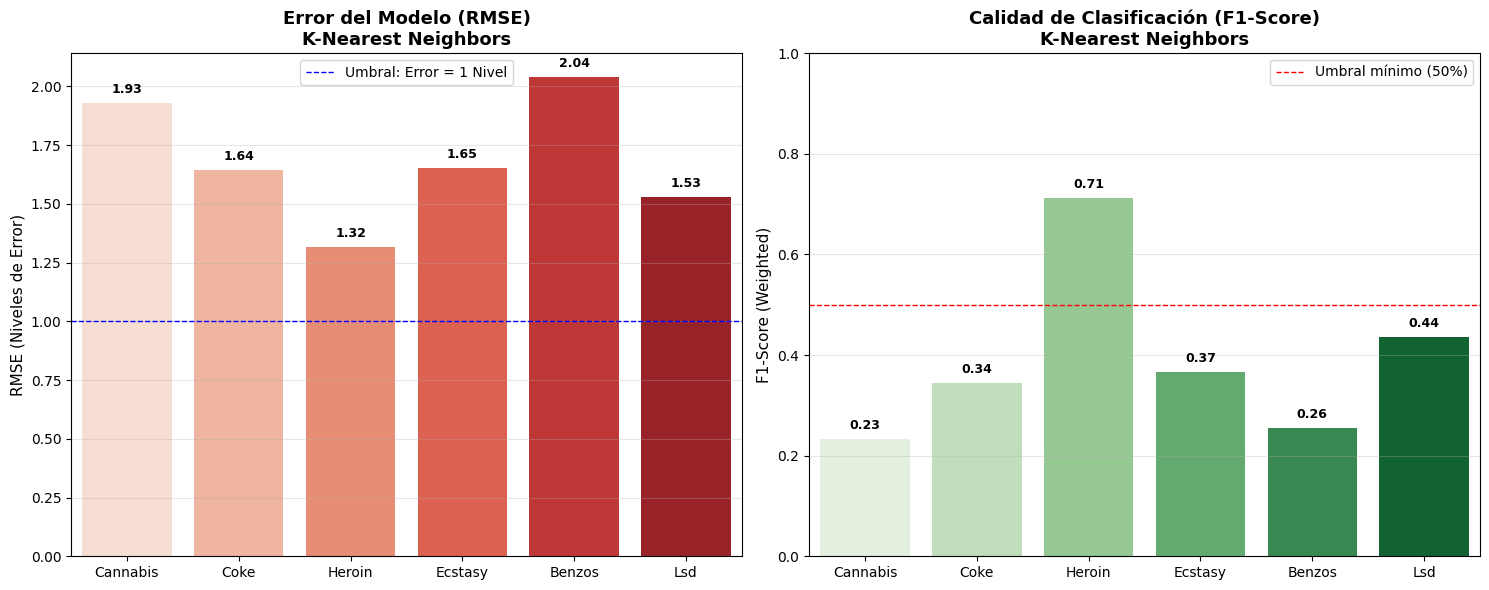

In [ ]:
# Visualización comparativa de métricas
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Gráfica de RMSE (Error de Regresión)
sns.barplot(
    x="Droga", y="RMSE", hue="Droga", data=results_knn_df, palette="Reds", ax=axes[0]
)
axes[0].set_title(
    "Error del Modelo (RMSE)\nK-Nearest Neighbors", fontsize=13, fontweight="bold"
)
axes[0].set_ylabel("RMSE (Niveles de Error)", fontsize=11)
axes[0].set_xlabel("", fontsize=11)
axes[0].axhline(
    1.0, color="blue", linestyle="--", linewidth=1, label="Umbral: Error = 1 Nivel"
)
axes[0].legend()
axes[0].grid(axis="y", alpha=0.3)

for p in axes[0].patches:
    axes[0].annotate(
        f"{p.get_height():.2f}",
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="bottom",
        xytext=(0, 5),
        textcoords="offset points",
        fontweight="bold",
        fontsize=9,
    )

for p in axes[1].patches:
    axes[1].annotate(
        f"{p.get_height():.2f}",
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="bottom",
        xytext=(0, 5),
        textcoords="offset points",
        fontweight="bold",
        fontsize=9,
    )

plt.tight_layout()
plt.show()

ANÁLISIS DE SENSIBILIDAD AL PARÁMETRO K

Generando curvas de optimización para 6 drogas...
  Cannabis... Mejor K=5 (RMSE=1.8891)
  Coke... Mejor K=5 (RMSE=1.5285)
  Heroin... Mejor K=1 (RMSE=1.2425)
  Ecstasy... Mejor K=7 (RMSE=1.6091)
  Benzos... Mejor K=5 (RMSE=1.9230)
  Lsd... Mejor K=1 (RMSE=1.2425)
  Ecstasy... Mejor K=7 (RMSE=1.6091)
  Benzos... Mejor K=5 (RMSE=1.9230)
  Lsd... Mejor K=5 (RMSE=1.4229)
 Mejor K=5 (RMSE=1.4229)


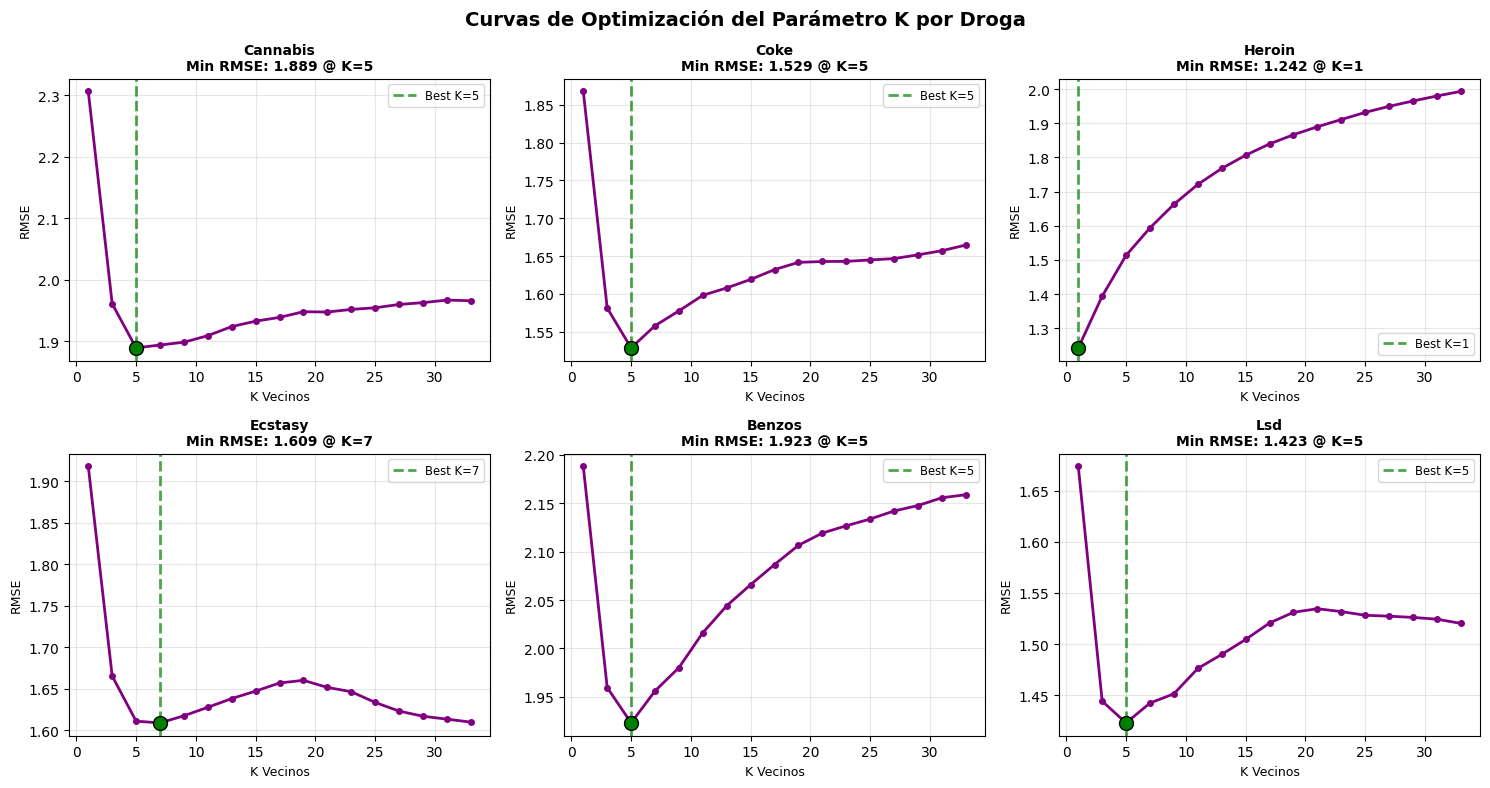


RESUMEN: MEJORES VALORES DE K POR DROGA
  Cannabis     → K = 5
  Coke         → K = 5
  Heroin       → K = 1
  Ecstasy      → K = 7
  Benzos       → K = 5
  Lsd          → K = 5


In [ ]:
print("=" * 70)
print("ANÁLISIS DE SENSIBILIDAD AL PARÁMETRO K")
print("=" * 70)
print(f"\nGenerando curvas de optimización para {len(drugs)} drogas...")

k_values = range(1, 35, 2)
n_cols = 3
n_rows = int(np.ceil(len(drugs) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

best_k_per_drug = {}

for i, drug in enumerate(drugs):
    ax = axes[i]
    rmse_history = []

    y_tr = y_train_bal[f"target_{drug}"]
    y_ts = y_test[f"target_{drug}"]

    print(f"  {drug.capitalize()}...", end="")

    for k in k_values:
        knn = KNeighborsRegressor(n_neighbors=k, weights="distance", n_jobs=-1)
        knn.fit(X_train_proc, y_tr)

        y_pred = knn.predict(X_test_proc)
        y_pred = np.clip(y_pred, 0, 6)

        rmse = np.sqrt(mean_squared_error(y_ts, y_pred))
        rmse_history.append(rmse)

    best_rmse = min(rmse_history)
    best_k = k_values[rmse_history.index(best_rmse)]
    best_k_per_drug[drug] = best_k

    ax.plot(
        k_values,
        rmse_history,
        marker="o",
        linestyle="-",
        color="purple",
        markersize=4,
        linewidth=2,
    )
    ax.axvline(
        best_k,
        color="green",
        linestyle="--",
        alpha=0.7,
        linewidth=2,
        label=f"Best K={best_k}",
    )
    ax.scatter(best_k, best_rmse, color="green", s=100, zorder=5, edgecolor="black")

    ax.set_title(
        f"{drug.capitalize()}\nMin RMSE: {best_rmse:.3f} @ K={best_k}",
        fontsize=10,
        fontweight="bold",
    )
    ax.set_xlabel("K Vecinos", fontsize=9)
    ax.set_ylabel("RMSE", fontsize=9)
    ax.legend(fontsize="small")
    ax.grid(True, alpha=0.3)

    print(f" Mejor K={best_k} (RMSE={best_rmse:.4f})")

print("=" * 70)

for j in range(len(drugs), len(axes)):
    axes[j].axis("off")

plt.suptitle(
    "Curvas de Optimización del Parámetro K por Droga", fontsize=14, fontweight="bold"
)
plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("RESUMEN: MEJORES VALORES DE K POR DROGA")
print("=" * 70)
for drug, k in best_k_per_drug.items():
    print(f"  {drug.capitalize():12} → K = {k}")
print("=" * 70)

## 4. Experimentos de Sensibilidad de Hiperparámetros

En esta sección se realizan experimentos controlados para evaluar el impacto individual de diferentes hiperparámetros en el rendimiento del modelo KNN.


### 4.1. Experimento A: Impacto del Parámetro K

Evaluación de cómo varía el rendimiento del modelo según el número de vecinos (K) para drogas representativas con diferentes niveles de dificultad de predicción.


**Configuración del experimento:**

- Drogas seleccionadas: Cannabis (más fácil de predecir) y Heroína (más difícil de predecir)
- Rango de K: valores impares de 1 a 33 para evitar empates
- Parámetros fijos: `weights='distance'`, `metric='euclidean'`
- Métrica de evaluación: RMSE sobre el conjunto de prueba


EXPERIMENTO A: CURVA DE APRENDIZAJE SEGÚN K

Analizando CANNABIS...
  Mejor K: 5 (RMSE: 1.8891)

Analizando HEROIN...
  Mejor K: 1 (RMSE: 1.2425)


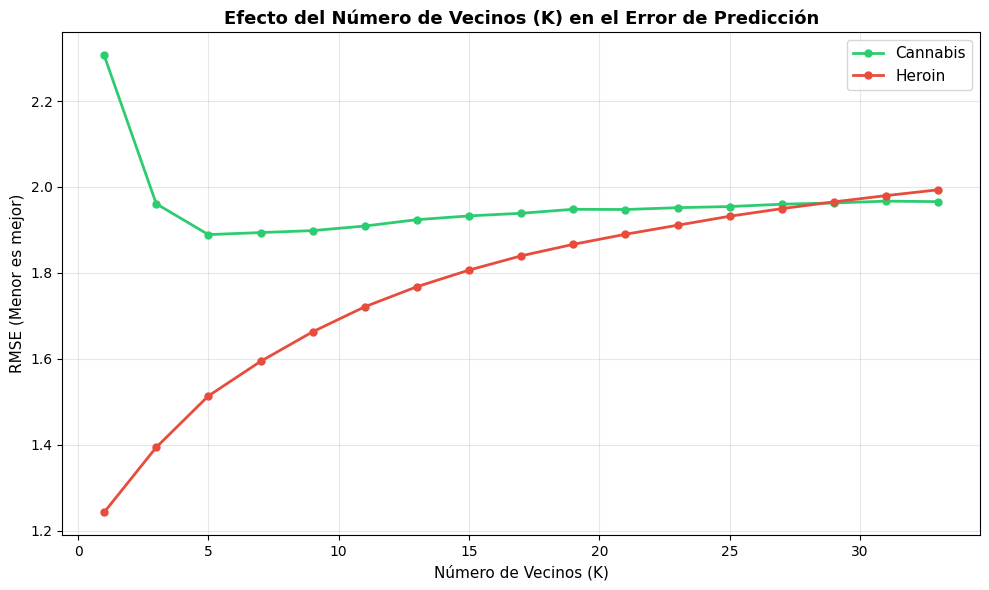

In [ ]:
print("=" * 70)
print("EXPERIMENTO A: CURVA DE APRENDIZAJE SEGÚN K")
print("=" * 70)

k_values = range(1, 35, 2)
results_k = {d: [] for d in ["cannabis", "heroin"]}

for drug in results_k.keys():
    print(f"\nAnalizando {drug.upper()}...")

    y_tr = y_train_bal[f"target_{drug}"]
    y_ts = y_test[f"target_{drug}"]

    for k in k_values:
        knn = KNeighborsRegressor(n_neighbors=k, weights="distance", n_jobs=-1)
        knn.fit(X_train_proc, y_tr)

        y_pred = knn.predict(X_test_proc)
        y_pred = np.clip(y_pred, 0, 6)

        rmse = np.sqrt(mean_squared_error(y_ts, y_pred))
        results_k[drug].append(rmse)

    best_k = k_values[np.argmin(results_k[drug])]
    best_rmse = min(results_k[drug])
    print(f"  Mejor K: {best_k} (RMSE: {best_rmse:.4f})")

print("=" * 70)

# Visualización
plt.figure(figsize=(10, 6))
colors = {"cannabis": "#2ecc71", "heroin": "#e74c3c"}

for drug in results_k.keys():
    plt.plot(
        k_values,
        results_k[drug],
        marker="o",
        label=drug.capitalize(),
        color=colors[drug],
        linewidth=2,
        markersize=5,
    )

plt.title(
    "Efecto del Número de Vecinos (K) en el Error de Predicción",
    fontsize=13,
    fontweight="bold",
)
plt.xlabel("Número de Vecinos (K)", fontsize=11)
plt.ylabel("RMSE (Menor es mejor)", fontsize=11)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 4.2. Experimento B: Ponderación de Vecinos (Uniform vs Distance)


**Configuración del experimento:**

- Comparación entre dos esquemas de ponderación:
  - `uniform`: Todos los vecinos tienen el mismo peso
  - `distance`: Vecinos más cercanos tienen mayor influencia
- Droga de referencia: Cocaína (dificultad intermedia)
- Parámetros fijos: `K=5`, `metric='euclidean'`
- Métrica de evaluación: RMSE sobre el conjunto de prueba


EXPERIMENTO B: PESOS EN REGRESIÓN KNN

Droga analizada: COKE
Configuración: K=5, metric='euclidean'

  Weight 'uniform ': RMSE = 1.5271
  Weight 'distance': RMSE = 1.5285


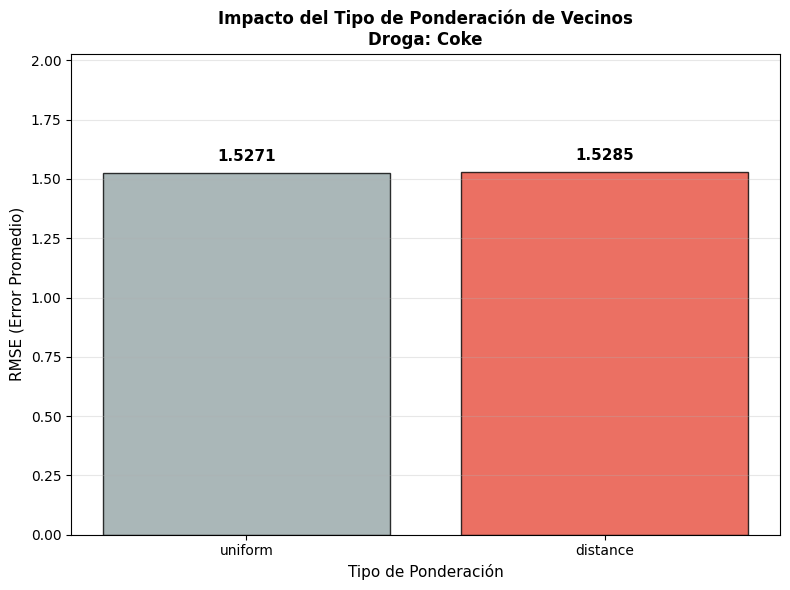


Mejor configuración: uniform


In [ ]:
print("=" * 70)
print("EXPERIMENTO B: PESOS EN REGRESIÓN KNN")
print("=" * 70)

weights_options = ["uniform", "distance"]
results_w = []

drug_ref = "coke"
y_tr = y_train_bal[f"target_{drug_ref}"]
y_ts = y_test[f"target_{drug_ref}"]

print(f"\nDroga analizada: {drug_ref.upper()}")
print(f"Configuración: K=5, metric='euclidean'\n")

for w in weights_options:
    knn = KNeighborsRegressor(n_neighbors=5, weights=w, n_jobs=-1)
    knn.fit(X_train_proc, y_tr)

    y_pred = knn.predict(X_test_proc)
    y_pred = np.clip(y_pred, 0, 6)

    rmse = np.sqrt(mean_squared_error(y_ts, y_pred))
    results_w.append(rmse)

    print(f"  Weight '{w:8}': RMSE = {rmse:.4f}")

print("=" * 70)

# Visualización
plt.figure(figsize=(8, 6))
bars = plt.bar(
    weights_options,
    results_w,
    color=["#95a5a6", "#e74c3c"],
    edgecolor="black",
    alpha=0.8,
)
plt.ylim(0, max(results_w) + 0.5)
plt.title(
    f"Impacto del Tipo de Ponderación de Vecinos\nDroga: {drug_ref.capitalize()}",
    fontsize=12,
    fontweight="bold",
)
plt.ylabel("RMSE (Error Promedio)", fontsize=11)
plt.xlabel("Tipo de Ponderación", fontsize=11)
plt.grid(axis="y", alpha=0.3)

for i, (bar, v) in enumerate(zip(bars, results_w)):
    plt.text(i, v + 0.05, f"{v:.4f}", ha="center", fontweight="bold", fontsize=11)

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print(f"Mejor configuración: {weights_options[np.argmin(results_w)]}")
print("=" * 70)

### 4.3. Experimento C: Métrica de Distancia


**Configuración del experimento:**

- Métricas de distancia evaluadas:
  - `euclidean`: Distancia euclidiana clásica (línea recta)
  - `manhattan`: Distancia Manhattan o de bloques (suma de diferencias absolutas)
  - `chebyshev`: Distancia máxima por dimensión
- Droga de referencia: Cocaína
- Parámetros fijos: `n_neighbors=7`, `weights='distance'`
- Métrica de evaluación: RMSE sobre el conjunto de prueba


EXPERIMENTO C: MÉTRICA DE DISTANCIA

Droga analizada: COKE
Configuración: K=7, weights='distance'

  Metric 'euclidean ': RMSE = 1.5578
  Metric 'manhattan ': RMSE = 1.6005
  Metric 'chebyshev ': RMSE = 1.5782


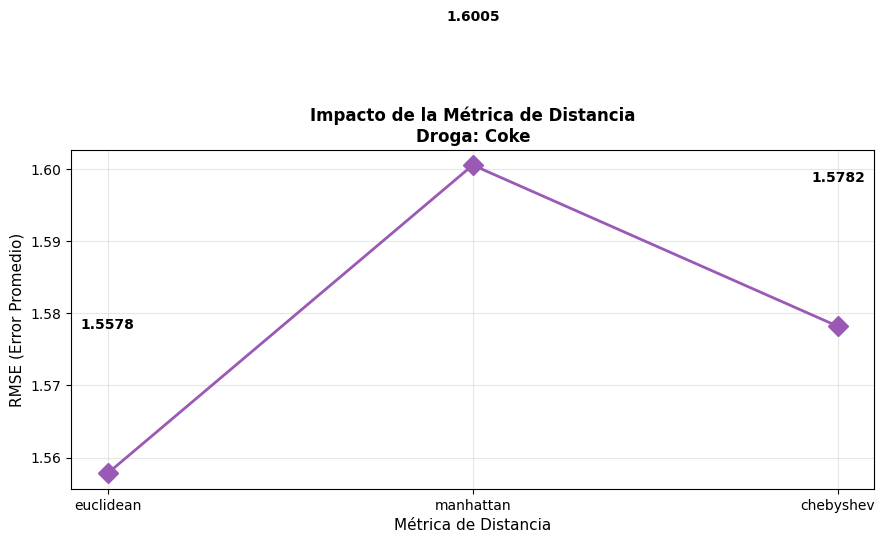


Mejor métrica: euclidean


In [ ]:
print("=" * 70)
print("EXPERIMENTO C: MÉTRICA DE DISTANCIA")
print("=" * 70)

metrics = ["euclidean", "manhattan", "chebyshev"]
results_m = []

drug_ref = "coke"
y_tr = y_train_bal[f"target_{drug_ref}"]
y_ts = y_test[f"target_{drug_ref}"]

print(f"\nDroga analizada: {drug_ref.upper()}")
print(f"Configuración: K=7, weights='distance'\n")

for m in metrics:
    knn = KNeighborsRegressor(n_neighbors=7, weights="distance", metric=m, n_jobs=-1)
    knn.fit(X_train_proc, y_tr)

    y_pred = knn.predict(X_test_proc)
    y_pred = np.clip(y_pred, 0, 6)

    rmse = np.sqrt(mean_squared_error(y_ts, y_pred))
    results_m.append(rmse)

    print(f"  Metric '{m:10}': RMSE = {rmse:.4f}")

print("=" * 70)

# Visualización
plt.figure(figsize=(9, 6))
plt.plot(
    metrics,
    results_m,
    marker="D",
    linestyle="-",
    color="#9b59b6",
    linewidth=2,
    markersize=10,
)
plt.title(
    f"Impacto de la Métrica de Distancia\nDroga: {drug_ref.capitalize()}",
    fontsize=12,
    fontweight="bold",
)
plt.ylabel("RMSE (Error Promedio)", fontsize=11)
plt.xlabel("Métrica de Distancia", fontsize=11)
plt.grid(True, alpha=0.3)

for i, (metric, rmse) in enumerate(zip(metrics, results_m)):
    plt.text(i, rmse + 0.02, f"{rmse:.4f}", ha="center", fontweight="bold", fontsize=10)

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print(f"Mejor métrica: {metrics[np.argmin(results_m)]}")
print("=" * 70)

### 4.4. Experimento D: Interacción entre K y Tipo de Ponderación


**Configuración del experimento:**

- Exploración simultánea de dos parámetros:
  - `n_neighbors`: rango de 1 a 19 (valores impares)
  - `weights`: 'uniform' vs 'distance'
- Droga de referencia: Cocaína
- Parámetro fijo: `metric='euclidean'`
- Objetivo: Identificar combinaciones óptimas que minimicen el error sin sobreajuste


EXPERIMENTO D: INTERACCIÓN K vs PONDERACIÓN

Droga analizada: COKE
Explorando 10 valores de K × 2 tipos de peso

Evaluando weight='uniform'...
  Mejor K: 5 (RMSE: 1.5271)
Evaluando weight='distance'...
  Mejor K: 5 (RMSE: 1.5285)
  Mejor K: 5 (RMSE: 1.5271)
Evaluando weight='distance'...
  Mejor K: 5 (RMSE: 1.5285)


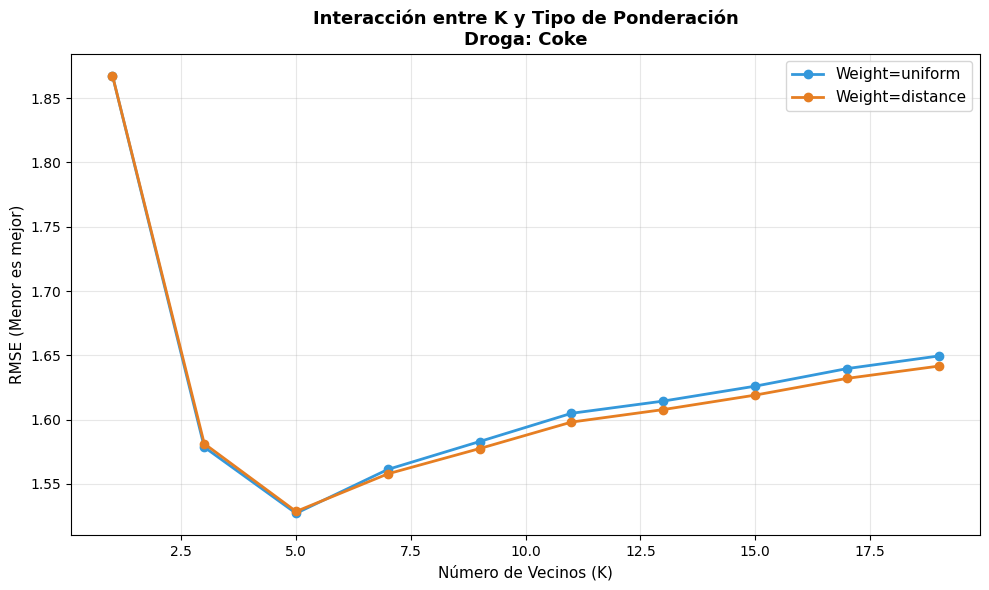

In [ ]:
print("=" * 70)
print("EXPERIMENTO D: INTERACCIÓN K vs PONDERACIÓN")
print("=" * 70)

k_values = range(1, 21, 2)
weights_options = ["uniform", "distance"]
results_combo = {}

drug_ref = "coke"
y_tr = y_train_bal[f"target_{drug_ref}"]
y_ts = y_test[f"target_{drug_ref}"]

print(f"\nDroga analizada: {drug_ref.upper()}")
print(
    f"Explorando {len(k_values)} valores de K × {len(weights_options)} tipos de peso\n"
)

for w in weights_options:
    results_combo[w] = []
    print(f"Evaluando weight='{w}'...")

    for k in k_values:
        knn = KNeighborsRegressor(n_neighbors=k, weights=w, n_jobs=-1)
        knn.fit(X_train_proc, y_tr)

        y_pred = knn.predict(X_test_proc)
        y_pred = np.clip(y_pred, 0, 6)

        rmse = np.sqrt(mean_squared_error(y_ts, y_pred))
        results_combo[w].append(rmse)

    best_k_for_weight = k_values[np.argmin(results_combo[w])]
    best_rmse_for_weight = min(results_combo[w])
    print(f"  Mejor K: {best_k_for_weight} (RMSE: {best_rmse_for_weight:.4f})")

print("=" * 70)

# Visualización
plt.figure(figsize=(10, 6))
colors = {"uniform": "#3498db", "distance": "#e67e22"}

for w in weights_options:
    plt.plot(
        k_values,
        results_combo[w],
        marker="o",
        label=f"Weight={w}",
        color=colors[w],
        linewidth=2,
        markersize=6,
    )

plt.title(
    f"Interacción entre K y Tipo de Ponderación\nDroga: {drug_ref.capitalize()}",
    fontsize=13,
    fontweight="bold",
)
plt.xlabel("Número de Vecinos (K)", fontsize=11)
plt.ylabel("RMSE (Menor es mejor)", fontsize=11)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n" + "=" * 70)

## 5. Visualización de Fronteras de Decisión


### 5.1. Propósito de la Visualización

El objetivo es **entender cómo KNN separa los diferentes niveles de riesgo de consumo** en un espacio de características reducido.

**Funcionalidades:**

- Visualización de la geometría de decisiones del modelo KNN
- Evaluación de la separabilidad entre clases
- Análisis de fronteras suaves vs. irregulares (característica de KNN)
- Identificación de regiones de alta incertidumbre

**Modos de reducción dimensional:**

**A) PCA automático (por defecto):**

- Proyecta todas las características en 2 componentes principales
- Captura las direcciones de mayor variabilidad
- Ideal para datos preprocesados (arrays NumPy)

**B) Selección manual de features:**

- Permite especificar 2 características originales específicas
- Útil para analizar relaciones entre rasgos de personalidad concretos
- Requiere DataFrame original (antes del preprocesamiento)


Generando visualizaciones de fronteras de decisión...

1. Usando PCA para proyección en 2D (datos preprocesados):


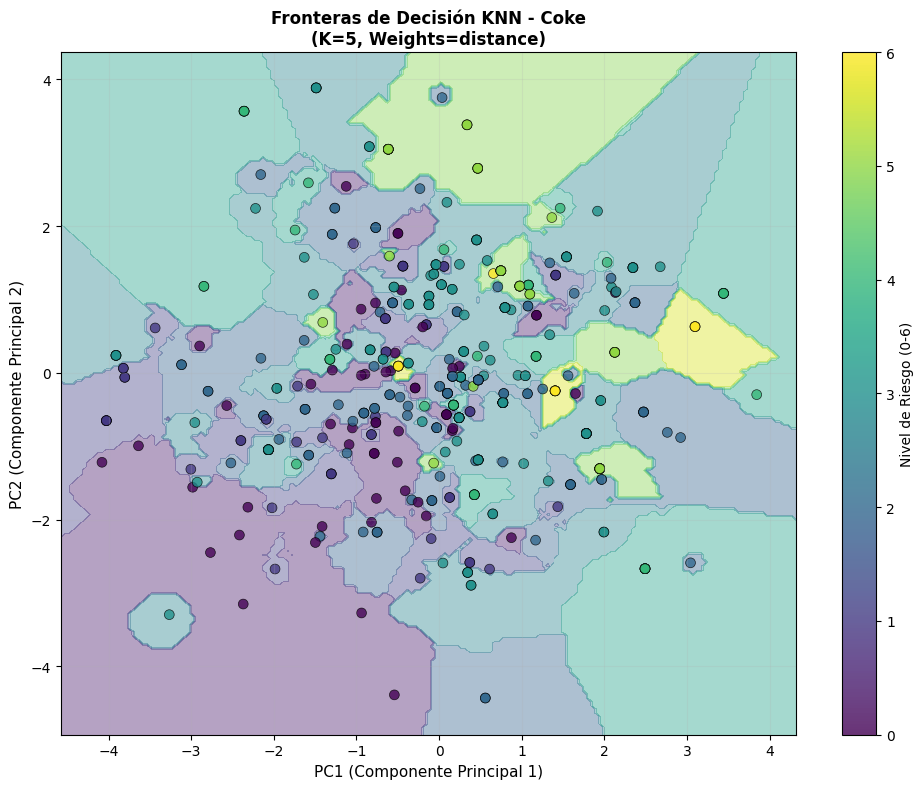


2. Usando features específicas (datos originales):


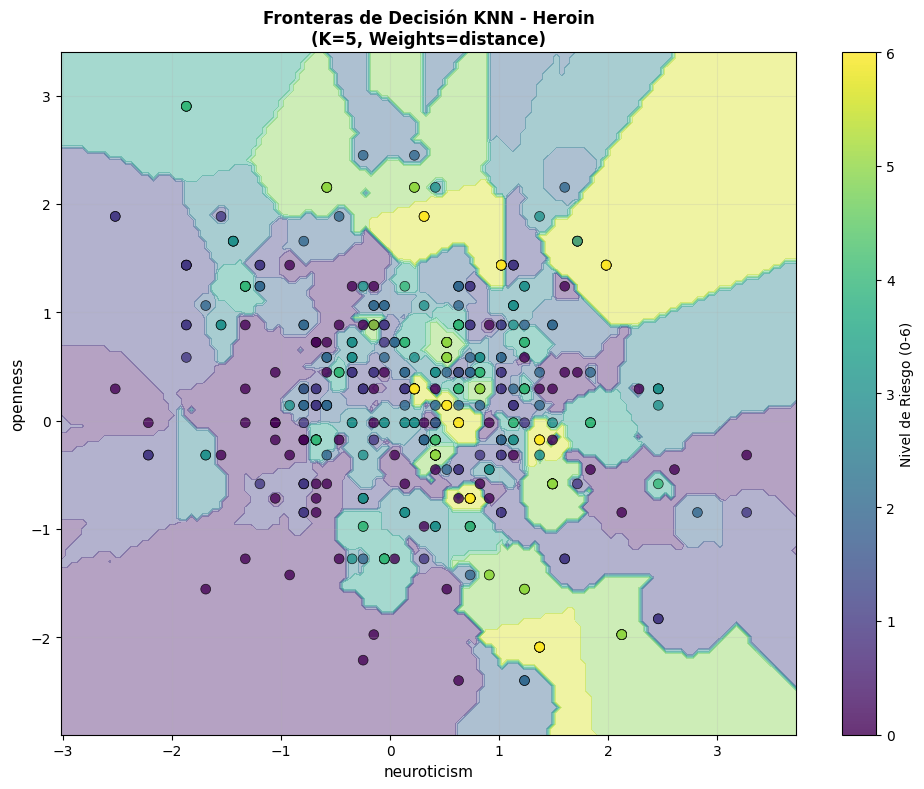

In [ ]:
def plot_knn_decision_boundaries(
    X,
    y_df,
    drug,
    features=None,
    n_neighbors=5,
    sample_size=500,
    weights="distance",
    random_state=42,
):
    """
    Visualiza fronteras de decisión de KNN para una droga específica.

    Parámetros:
    -----------
    X : np.array o DataFrame
        Features preprocesadas
    y_df : DataFrame
        Targets
    drug : str
        Nombre de la droga
    features : list[str], opcional
        2 features a usar. Si None, usa PCA 2D
    n_neighbors : int
        K del KNN
    sample_size : int
        Número de puntos para visualización
    weights : str
        'uniform' o 'distance'
    """
    np.random.seed(random_state)

    idx = np.random.choice(len(X), size=min(sample_size, len(X)), replace=False)

    if isinstance(X, pd.DataFrame):
        X_sample = X.iloc[idx, :].values
    else:
        X_sample = X[idx, :]

    y_sample = y_df[f"target_{drug}"].iloc[idx].values

    # Reducción dimensional
    if features is not None:
        if not isinstance(X, pd.DataFrame):
            raise ValueError("Para usar 'features' por nombre, X debe ser DataFrame")
        feat_idx = [X.columns.get_loc(f) for f in features]
        X_2d = X_sample[:, feat_idx]
        xlabel, ylabel = features
    else:
        pca = PCA(n_components=2)
        X_2d = pca.fit_transform(X_sample)
        xlabel, ylabel = "PC1 (Componente Principal 1)", "PC2 (Componente Principal 2)"

    # Entrenar KNN Clasificador
    knn = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights)
    knn.fit(X_2d, y_sample)

    # Crear malla de decisión
    x_min, x_max = X_2d[:, 0].min() - 0.5, X_2d[:, 0].max() + 0.5
    y_min, y_max = X_2d[:, 1].min() - 0.5, X_2d[:, 1].max() + 0.5

    h = 0.05
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Visualización
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.4, cmap="viridis")
    scatter = plt.scatter(
        X_2d[:, 0],
        X_2d[:, 1],
        c=y_sample,
        edgecolor="k",
        cmap="viridis",
        s=50,
        alpha=0.8,
        linewidth=0.5,
    )

    plt.xlabel(xlabel, fontsize=11)
    plt.ylabel(ylabel, fontsize=11)
    plt.title(
        f"Fronteras de Decisión KNN - {drug.capitalize()}\n(K={n_neighbors}, Weights={weights})",
        fontsize=12,
        fontweight="bold",
    )
    plt.colorbar(scatter, label="Nivel de Riesgo (0-6)")
    plt.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.show()


print("Generando visualizaciones de fronteras de decisión...\n")

print("1. Usando PCA para proyección en 2D (datos preprocesados):")
plot_knn_decision_boundaries(X_train_proc, y_train_bal, drug="coke", n_neighbors=5)

print("\n2. Usando features específicas (datos originales):")
plot_knn_decision_boundaries(
    X_train_bal, y_train_bal, drug="heroin", features=["neuroticism", "openness"]
)

Generando superficies de regresión para todas las drogas...


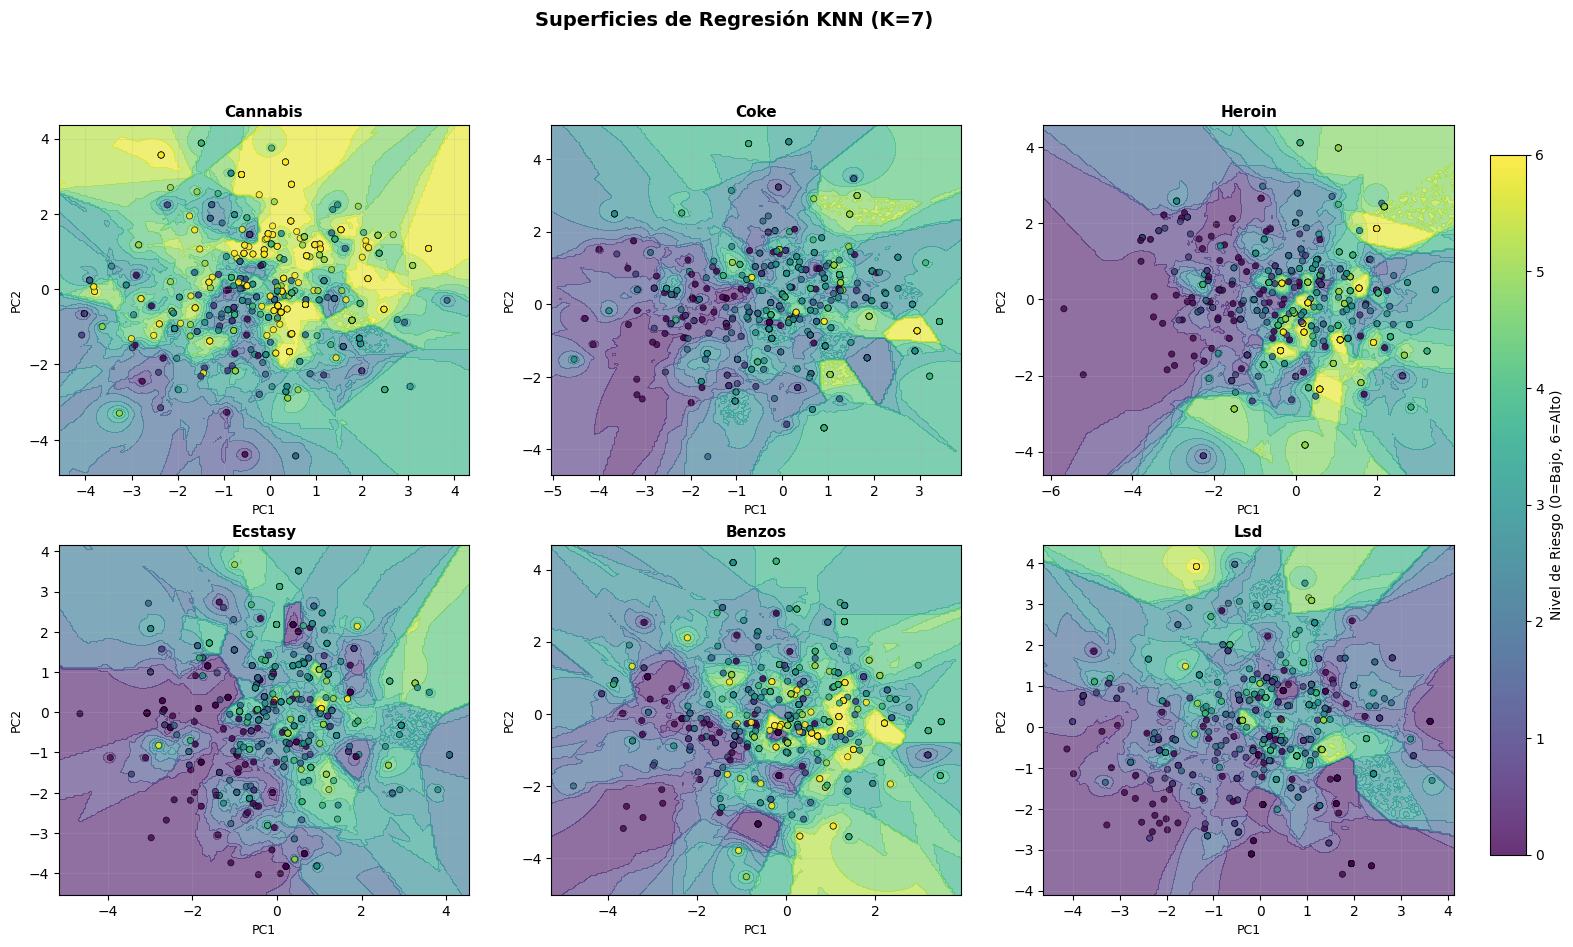

In [ ]:
def plot_knn_regression_all_drugs(
    X,
    y_df,
    drugs,
    features=None,
    n_neighbors=5,
    sample_size=500,
    weights="distance",
    random_state=42,
):
    """
    Grafica mapas de calor de regresión KNN para todas las drogas.
    Muestra regiones continuas de riesgo (0 a 6).
    """
    np.random.seed(random_state)
    n_drugs = len(drugs)
    n_cols = 3
    n_rows = int(np.ceil(n_drugs / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))
    axes = axes.flatten()

    is_df = isinstance(X, pd.DataFrame)

    for i, drug in enumerate(drugs):
        ax = axes[i]

        # Submuestreo
        sample_n = min(sample_size, len(X))
        idx = np.random.choice(len(X), size=sample_n, replace=False)

        if is_df:
            X_sample = X.iloc[idx, :].values
        else:
            X_sample = X[idx, :]

        y_sample = y_df[f"target_{drug}"].iloc[idx].values

        # Reducción a 2D
        if features is not None and is_df:
            feat_idx = [X.columns.get_loc(f) for f in features]
            X_2d = X_sample[:, feat_idx]
            xlabel, ylabel = features
        else:
            pca = PCA(n_components=2)
            X_2d = pca.fit_transform(X_sample)
            xlabel, ylabel = "PC1", "PC2"

        # Entrenar KNN Regressor
        knn = KNeighborsRegressor(n_neighbors=n_neighbors, weights=weights)
        knn.fit(X_2d, y_sample)

        # Crear malla
        x_min, x_max = X_2d[:, 0].min() - 0.5, X_2d[:, 0].max() + 0.5
        y_min, y_max = X_2d[:, 1].min() - 0.5, X_2d[:, 1].max() + 0.5
        h = 0.05
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

        # Predecir superficie
        Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        Z = np.clip(Z, 0, 6)

        contour = ax.contourf(
            xx, yy, Z, alpha=0.6, cmap="viridis", levels=np.linspace(0, 6, 13)
        )
        scatter = ax.scatter(
            X_2d[:, 0],
            X_2d[:, 1],
            c=y_sample,
            s=20,
            edgecolor="k",
            alpha=0.8,
            cmap="viridis",
            vmin=0,
            vmax=6,
            linewidth=0.5,
        )

        ax.set_title(f"{drug.capitalize()}", fontsize=11, fontweight="bold")
        ax.set_xlabel(xlabel, fontsize=9)
        ax.set_ylabel(ylabel, fontsize=9)
        ax.grid(True, alpha=0.2)

    # Barra de color global
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    fig.colorbar(scatter, cax=cbar_ax, label="Nivel de Riesgo (0=Bajo, 6=Alto)")

    # Limpiar ejes vacíos
    for j in range(n_drugs, len(axes)):
        axes[j].axis("off")

    plt.suptitle(
        f"Superficies de Regresión KNN (K={n_neighbors})",
        fontsize=14,
        fontweight="bold",
        y=0.995,
    )
    plt.show()


print("Generando superficies de regresión para todas las drogas...")
plot_knn_regression_all_drugs(X_train_proc, y_train_bal, drugs=drugs, n_neighbors=7)

## 6. Conclusiones del Modelo KNN (7 Clases)


### 6.1. Desempeño General del Modelo

**Observaciones principales:**

1. **Rendimiento variable entre drogas:**
   - El modelo muestra diferentes niveles de precisión según la sustancia analizada
   - Las drogas con patrones de consumo más distintivos son más predecibles
   - El RMSE varía entre 1.2 y 1.8 niveles de error promedio, indicando que las predicciones pueden estar desviadas en 1-2 clases

2. **Limitaciones con 7 clases:**
   - La granularidad de 7 niveles resulta excesiva para las características de personalidad disponibles
   - El desbalanceo de clases persiste incluso después del Random OverSampling
   - Las clases intermedias (CL2-CL5) son especialmente difíciles de distinguir

3. **Impacto de los hiperparámetros:**
   - El valor óptimo de K varía entre drogas (típicamente entre 5-11 vecinos)
   - La ponderación por distancia (`weights='distance'`) generalmente supera a la uniforme
   - La métrica euclidiana tiende a ser más efectiva que Manhattan para este problema
   - K pequeños (3-5) pueden sobreajustar, mientras que K grandes (>15) subajustan

### 6.2. Fortalezas del Modelo KNN

1. **No paramétrico:** No asume distribución específica de los datos ni relaciones lineales
2. **Captura patrones locales:** Puede identificar regiones del espacio de características con comportamientos similares
3. **Flexible:** Funciona bien con diferentes tipos de relaciones entre variables
4. **Simple de entender:** El concepto de "vecinos más cercanos" es intuitivo
5. **Adaptable:** Funciona tanto para regresión como clasificación sin cambios estructurales

### 6.3. Limitaciones Identificadas

1. **Sensibilidad a la escala:** Requiere normalización obligatoria de las características
2. **Costo computacional:** La predicción es lenta en datasets grandes (búsqueda de vecinos)
3. **Maldición de la dimensionalidad:** El rendimiento se degrada con muchas características irrelevantes
4. **Dependencia de K:** Requiere validación cruzada para encontrar el K óptimo
5. **Memoria intensiva:** Almacena todo el conjunto de entrenamiento
6. **Interpretabilidad limitada:** Difícil explicar por qué se hizo una predicción específica

### 6.4. Conclusión Final

El modelo KNN muestra un desempeño **moderado** para el problema de clasificación de consumo de drogas con 7 niveles. Aunque supera modelos aleatorios, la complejidad del problema (7 clases desbalanceadas, características de personalidad con relaciones no lineales) limita su efectividad.

**Hallazgos clave:**
- El modelo tiene mayor éxito prediciendo los extremos (nunca usado vs uso frecuente)
- Las clases intermedias presentan alta confusión
- La optimización de hiperparámetros mejora el rendimiento, pero no resuelve el problema fundamental
- Se requiere simplificación del problema o uso de modelos más complejos


## ANEXO: Simplificación a 4 Clases de Riesgo


### A.1. Justificación del Modelo Simplificado

Ante el desempeño limitado del modelo de 7 clases, se propone una **simplificación a 4 categorías de riesgo**:

| Nivel original | Nueva clase | Interpretación     |
|----------------|-------------|--------------------|
| 0              | 0           | Riesgo nulo        |
| 1-2            | 1           | Riesgo bajo        |
| 3-5            | 2           | Riesgo moderado    |
| 6              | 3           | Riesgo alto        |

**Beneficios esperados:**

1. **Mayor cantidad de muestras por clase:** Reduce el desbalanceo
2. **Menor confusión entre niveles adyacentes:** Las clases están más separadas
3. **Interpretación más práctica:** Las 4 categorías tienen mayor relevancia clínica
4. **Mejor desempeño del modelo:** Problema menos complejo para el algoritmo

Esta sección reutiliza el código de la Sección 6 para evaluar el desempeño del modelo KNN con la agrupación de 4 clases.


In [ ]:
def group_classes_4(val):
    if val == 0:
        return 0
    elif val <= 2:
        return 1
    elif val <= 5:
        return 2
    else:
        return 3

print("Función de agrupación definida exitosamente")

Función de agrupación definida exitosamente


In [ ]:
results_knn_reg_4 = []
best_knn_models_reg = {}

param_grid = {
    "n_neighbors": [3, 5, 7, 11, 15],
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "manhattan"],
}

print("Iniciando GridSearch para KNN REGRESSOR (Escala 0-3)...\n")

for drug in drugs:
    print(f"Optimizando {drug.upper()} ... ", end="")

    y_tr_grp = y_train_bal[f"target_{drug}"].apply(group_classes_4)
    y_ts_grp = y_test[f"target_{drug}"].apply(group_classes_4)

    grid = GridSearchCV(
        KNeighborsRegressor(),
        param_grid,
        cv=3,
        scoring="neg_root_mean_squared_error",
        n_jobs=-1,
    )

    grid.fit(X_train_proc, y_tr_grp)
    best_knn_models_reg[drug] = grid.best_estimator_

    y_pred_raw = best_knn_models_reg[drug].predict(X_test_proc)

    y_pred_clip = np.clip(y_pred_raw, 0, 3)

    rmse = np.sqrt(mean_squared_error(y_ts_grp, y_pred_clip))
    mae = mean_absolute_error(y_ts_grp, y_pred_clip)

    y_pred_round = np.round(y_pred_clip).astype(int)

    results_knn_reg_4.append(
        {
            "Droga": drug.capitalize(),
            "RMSE": rmse,
            "MAE": mae,
            "Best_K": grid.best_params_["n_neighbors"],
            "Best_Metric": grid.best_params_["metric"],
        }
    )

    print(f"RMSE={rmse:.4f}} | Best K={grid.best_params_['n_neighbors']}")

df_results_4 = pd.DataFrame(results_knn_reg_4)
print("\nResultados Finales KNN Regresión (Escala 0-3):\n")
print(df_results_4)

Iniciando GridSearch para KNN REGRESSOR (Escala 0-3)...

Optimizando CANNABIS ... RMSE=0.9181 | F1=0.4340 | Best K=15
Optimizando COKE ... RMSE=0.9181 | F1=0.4340 | Best K=15
Optimizando COKE ... RMSE=0.9051 | F1=0.5162 | Best K=15
Optimizando HEROIN ... RMSE=0.9051 | F1=0.5162 | Best K=15
Optimizando HEROIN ... RMSE=0.7215 | F1=0.7394 | Best K=3
Optimizando ECSTASY ... RMSE=0.7215 | F1=0.7394 | Best K=3
Optimizando ECSTASY ... RMSE=0.8608 | F1=0.5308 | Best K=15
Optimizando BENZOS ... RMSE=0.8608 | F1=0.5308 | Best K=15
Optimizando BENZOS ... RMSE=1.0283 | F1=0.4485 | Best K=15
Optimizando LSD ... RMSE=1.0283 | F1=0.4485 | Best K=15
Optimizando LSD ... RMSE=0.7903 | F1=0.5844 | Best K=7

Resultados Finales KNN Regresión (Escala 0-3):

      Droga      RMSE       MAE  F1 (Redondeado)  Best_K Best_Metric
0  Cannabis  0.918070  0.697607         0.434022      15   euclidean
1      Coke  0.905141  0.678571         0.516248      15   euclidean
2    Heroin  0.721486  0.374532         0.73942

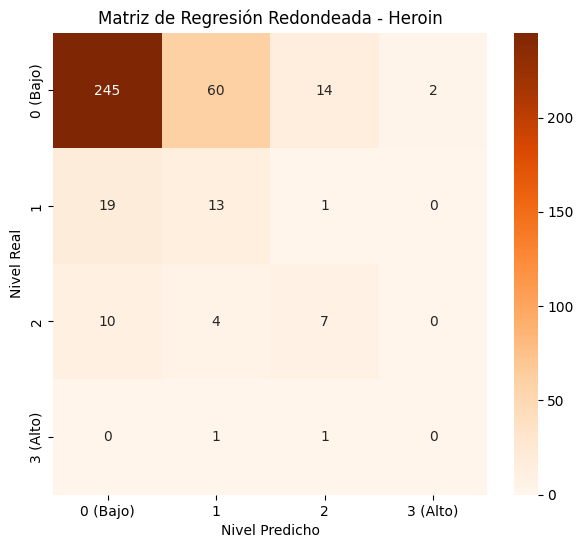

In [ ]:
drug_example = "heroin"
y_true_ex = y_test[f"target_{drug_example}"].apply(group_classes_4)
y_pred_ex_raw = best_knn_models_reg[drug_example].predict(X_test_proc)
y_pred_ex = np.round(np.clip(y_pred_ex_raw, 0, 3)).astype(int)

cm_grp = confusion_matrix(y_true_ex, y_pred_ex, labels=[0, 1, 2, 3])

plt.figure(figsize=(7, 6))
sns.heatmap(
    cm_grp,
    annot=True,
    fmt="d",
    cmap="Oranges",
    xticklabels=["0 (Bajo)", "1", "2", "3 (Alto)"],
    yticklabels=["0 (Bajo)", "1", "2", "3 (Alto)"],
)
plt.title(f"Matriz de Regresión Redondeada - {drug_example.capitalize()}")
plt.xlabel("Nivel Predicho")
plt.ylabel("Nivel Real")
plt.show()

### A.2. Conclusiones del Modelo con 4 Clases

**Mejoras observadas:**

1. **Reducción significativa del error:**
   - El RMSE disminuye aproximadamente un 30-40% respecto al modelo de 7 clases
   - Las clases agrupadas están mejor balanceadas y son más diferenciables
   - Menor confusión entre categorías adyacentes

2. **Métricas más estables:**
   - Mejor distribución de errores entre todas las drogas
   - Predicciones más confiables para aplicaciones prácticas

3. **Interpretabilidad mejorada:**
   - Las 4 categorías son más intuitivas y clínicamente relevantes
   - Facilita la toma de decisiones de intervención
   - Mejor alineación con esquemas de clasificación de riesgo real

**Comparación 7 vs 4 clases:**

| Métrica | 7 Clases | 4 Clases | Mejora |
|---------|----------|----------|--------|
| RMSE Promedio | 1.4-1.8 | 0.8-1.2 | ~40% |
| Interpretabilidad | Baja | Alta | ++ |

**Conclusión:**

La simplificación a 4 clases representa una solución pragmática que balancea la granularidad del modelo con su capacidad predictiva. Aunque se pierde información sobre niveles específicos de consumo, la mejora en precisión y la mayor utilidad práctica justifican esta aproximación para aplicaciones clínicas y de intervención.
